<a href="https://colab.research.google.com/github/carlos-andre-henrique/Regressao/blob/main/39_S%C3%A9ries_Temporais_Pr%C3%A1tica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais - Prática

In [28]:
# Importarei as principais bibliotecas

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

In [29]:
# Realizarei o pip install de algumas bibliotecas

!pip install scipy
!pip install pmdarima

from pmdarima.arima import auto_arima

In [30]:
# Importarei a base de dados

df = pd.read_excel("energy.xlsx", index_col= "DATE", parse_dates=True)
df.head()

,energy
DATE,
1985-01-01,71.5920
1985-02-01,69.7870
1985-03-01,61.6790
1985-04-01,56.7479
1985-05-01,54.6165


In [31]:
# Realizarei algumas análises

df.shape

(408, 1)

In [32]:
df.describe()

,energy
count,408.000000
mean,88.062232
std,15.168540
min,54.616500
25%,76.499750
50%,88.940450
75%,99.733200
max,126.362600


De acordo com o resultado do describe, verifica-se uma mediana muito próximo da média.

    mean = 88.062232
    50%  = 88.940450

In [33]:
# Verificarei a primeira e a última data

df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

In [34]:
# Renomearei a coluna "energy"

df.columns = ["producao"]

<Axes: xlabel='DATE'>

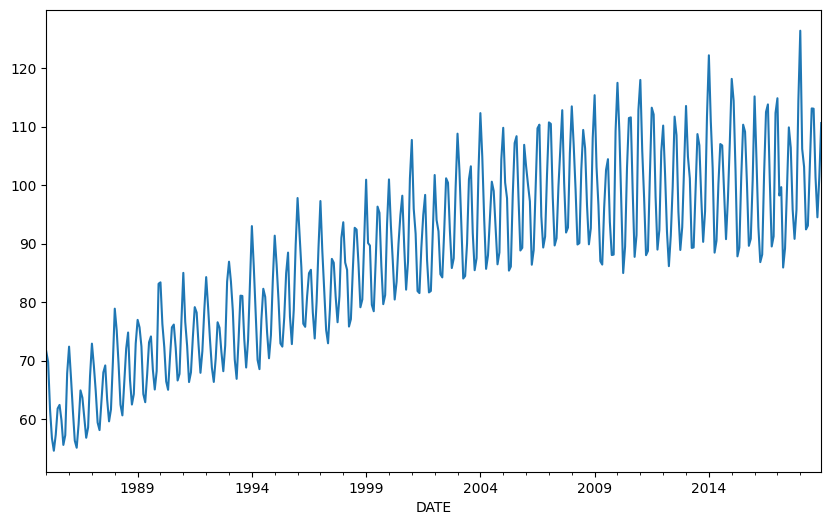

In [35]:
# Analisarei os dados com o gráfico

df["producao"].plot(figsize=(10,6))

Pelo gráfico, percebe-se alguma sazonalidade e uma tendência de alta em 2019

<Figure size 800x600 with 0 Axes>

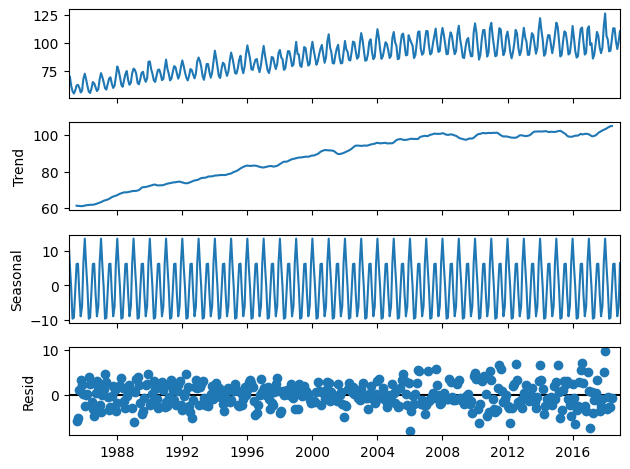

In [36]:
# Realizarei uma decomposição sazonal
# Utilizarei uma métrica para conseguir observar se existe uma sazonalidade e se existe uma tendência de alta ou baixa:

from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df)

fig = plt.figure(figsize=(8,6))
fig = resultado.plot()



*   Trend é a tendência, verifica-se que existe uma tendência de alta;
*   Seasonal mostra a sazonalidade através dos picos do gráfico;
*   Resid mostra o resíduo e o quanto estão próximas ou distante da média.


In [37]:
# Realizarei o teste de estacionaridade
# Uma série estacionária quer dizer que não existe sazionalidade.
# Realizarei o teste do adf e do p-valor:
    # Se p-valor maior que 5% = hipótese nula é verdadeira = não é estacionária = há sazonalidade

from statsmodels.tsa.stattools import adfuller

result = adfuller(df["producao"].dropna())
print(f"teste ADF:{result[0]}")
print(f"p valor:{result[1]}")

teste ADF:-2.252399047046594
p valor:0.18777984601967806


Nota-se que o p-valor deu maior que 5%, entende-se que a série não é estacionária, a hipótese nula é verdadeira.

Realizarei outro teste para ver se há diferença entre o dia atual e o dia anterior, se tomando esse valor como uma nova variável, se essa base irá ou não ser estacionária:

In [38]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["producao"].diff().dropna())
print(f"teste ADF:{result[0]}")
print(f"p valor:{result[1]}")

teste ADF:-7.450892277526341
p valor:5.67456995585561e-11


O diff pega o valor da linha debaixo e o traz para a de cima, tirando a diferença entre uma e outra

Agora pode-se rejeitar a hipótese nula, a série é sim estacionária. Porque devido ao número, em notação científica,  tem-se um valor muito menor que 5%.

Posso seguir com a análise. Vou escolher qual será o melhor parâmetro para utilizar no ARIMA:

In [39]:
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                       seasonal=True,
                       m=6,
                       D=1,
                       start_P=1,
                       start_Q=1,
                       max_P=2,
                       max_Q=2,
                       information_criterion="aic",
                       trace=True,
                       error_action="ignore",
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1968.148, Time=0.89 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2494.965, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=2053.701, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2128.799, Time=0.46 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2064.883, Time=0.34 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1928.298, Time=0.79 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=1868.200, Time=2.02 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=1866.400, Time=2.36 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=2014.153, Time=1.00 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=1916.488, Time=1.53 sec
 ARIMA(1,1,0)(1,1,2)[6]             : AIC=1936.850, Time=2.07 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=1868.120, Time=3.55 sec
 ARIMA(1,1,2)(1,1,2)[6]             : AIC=1

Após a montagem de todas as combinações dos parâmetros P e Q, apresenta-se o AIC de cada um.

Encontrado o meu melhor parâmetro, posso utilizar o SARIMAX:

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df, order=(1,1,1), seasonal_order=(1,1,2,6))
resultado_sarimax = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
# Verificarei o resultado do modelo:

resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                               producao   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 6)   Log Likelihood                -927.200
Date:                                Fri, 18 Aug 2023   AIC                           1866.400
Time:                                        02:42:35   BIC                           1890.364
Sample:                                    01-01-1985   HQIC                          1875.889
                                         - 12-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5125      0.042     12.156      0.000       0.430       0.595
ma.L1         -0.9601      0.017    -56.250      0.000      -0.994      -0.927
ar.S.L6       -0.9973      0.003   -350.055      0.000      -1.003      -0.992
ma.S.L6        0.1026      0.037      2.775      0.006       0.030       0.175
ma.S.L12      -0.7748      0.035    -22.180      0.000      -0.843      -0.706
sigma2         5.6413      0.322     17.544      0.000       5.011       6.272
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                29.17
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
# Realizarei o predict. Definirei quantos dias atrás eu quero que o modelo seja testado:

predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [43]:
# Identificarei o intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(115.1447404570401, 124.45517675290846)

In [44]:
# Verificarei a predição média:

predicao_media[0]

119.79995860497428

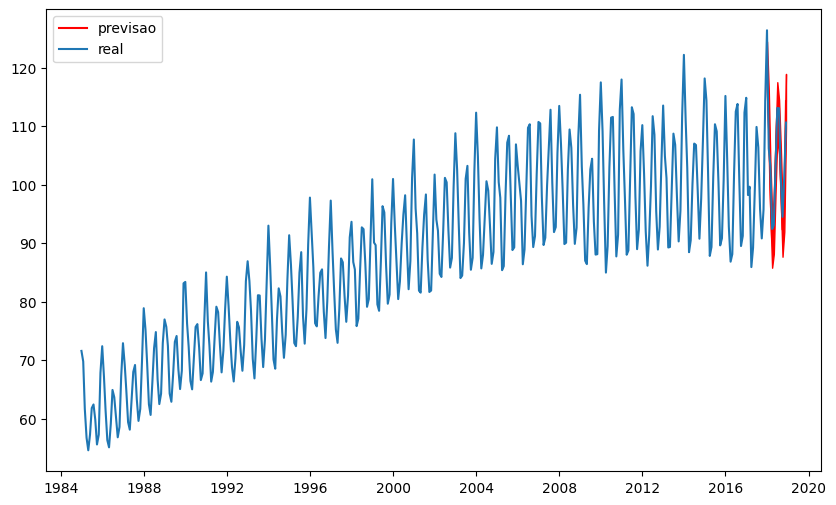

In [45]:
# Realizarei a predição de forma gráfica

datas_previsao= np.asarray(predicao_media.index)
datas = np.asarray(df.index)

plt.figure(figsize=(10,6))
plt.plot(datas_previsao, predicao_media.values, color = "red", label = "previsao")
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color = "red")
plt.plot(datas, df.values, label = "real")
plt.legend()
plt.show()

In [46]:
# Calcularei o R^2:

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(df[-12:].values, predicao_media.values)
print(mae)

2.7071201498891306


In [48]:
# Realizarei a previsão do Forescast:

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [54]:
# Identificarei o intervalo de confiança

intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]

(91.38813005236821, 103.10930985132882)

In [56]:
# Veficarei o forescast médio

forecast_medio[10]

97.24871995184851

In [57]:
# Realizarei a predição:

datas_forecast = np.asarray(forecast_medio.index)
pred_dates = np.asarray(predicao_media.index)

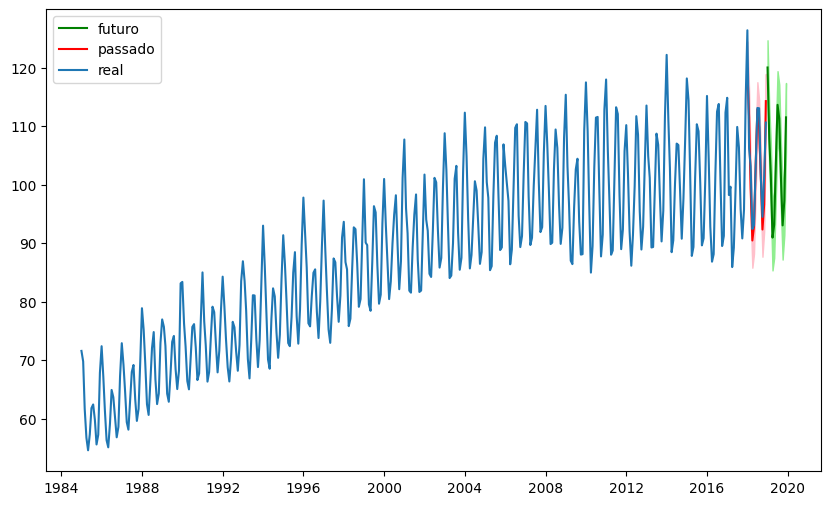

In [62]:
# Plotarei o gráfico tanto na predição passada quanto na futura:

dates = np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast, forecast_medio.values, color = "green", label="futuro")
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color="lightgreen")

plt.plot(datas_previsao, predicao_media.values, color="red", label="passado")
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color="pink")

plt.plot(dates, df.values, label="real")
plt.legend(loc="upper left")
plt.show()